In [1]:
import trackerlib
from csat2 import misc, ECMWF, GOES
from csat2.ECMWF.ECMWF import _calc_eis
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import time
import xarray as xr
import numpy.ma as ma
#from advection_funcs import subset_around_point
import matplotlib.patches as mpatches
import math
import cftime
from scipy.optimize import curve_fit
from netCDF4 import Dataset
import datetime
from matplotlib.colors import LogNorm
from advection_functions import advection_funcs,GOES_AMSR_colocation,LWP_correction_funcs
import pvlib
import pandas as pd


In [2]:
### specify the initial time of the initial parcel
year, doy, hour = 2020, 92, 15 # Year, day of year, hour of day, note 17:00 UTC corresponds to 9am local time in california, 15UTC is 7am local time
init_time = misc.time.ydh_to_datetime(year, doy, hour)
time_step = datetime.timedelta(hours=0.5)  # Time step of the integration, this is 30 mins by default

n_trajectories = 1  # number of trajectories to run, since we start consecutive trajectories from the same initial position, this is the number of initial hours to loop over

t_step = 24 # time step in hours between setting off successive trajectories

rho_w = 1000 # density of water kg/m^3

time_between_trajectroies = datetime.timedelta(hours=t_step) # time between each trajectory, annoyingly this has to be equal to t_step for my current implementation

time_advected = 24 # number of hours each parcel is advected for, something on order of days is appropriate, but use a small value for testing

total_time = datetime.timedelta(hours=time_advected) + datetime.timedelta(hours=(n_trajectories -1)*t_step) # total time of the integration
hours, seconds = divmod(total_time.total_seconds(), 3600)
minutes = seconds // 60
#init_position = np.array([initial_lon, initial_lat])  # Initial position of the air parcel
#winddata = ECMWF.ERA5WindData(level="1000hPa",res="0.25grid",linear_interp="both") # wind data on 1 degree grid, linearly interpolated in space and time
n_steps = int(total_time.total_seconds() / time_step.total_seconds()) +1 # Number of steps in the integration, add one on to account for the initial position
channel =7 # GOES channel of interest, note that this is the same resolution as the phase data

times = [init_time + i * time_step for i in range(n_steps)] # List of times for the integration

start_of_year = datetime.datetime(year, 1, 1) 
GOES_doy = [(dt - start_of_year).days + 1 for dt in times] ##
GOES_doy = [f"{doy:03d}" for doy in GOES_doy] ## format so it is 3 digits long i.e. 001 for 1st Jan

GOES_times = np.array([dt.strftime("%H%M") for dt in times]) ## list of times in the format HHMM, note this will have shape length of single trajectory + t_step * successive trajectories/ time_step

GOES_timestamps = pd.to_datetime(times)



In [3]:
print(times)

[datetime.datetime(2020, 4, 1, 15, 0), datetime.datetime(2020, 4, 1, 15, 30), datetime.datetime(2020, 4, 1, 16, 0), datetime.datetime(2020, 4, 1, 16, 30), datetime.datetime(2020, 4, 1, 17, 0), datetime.datetime(2020, 4, 1, 17, 30), datetime.datetime(2020, 4, 1, 18, 0), datetime.datetime(2020, 4, 1, 18, 30), datetime.datetime(2020, 4, 1, 19, 0), datetime.datetime(2020, 4, 1, 19, 30), datetime.datetime(2020, 4, 1, 20, 0), datetime.datetime(2020, 4, 1, 20, 30), datetime.datetime(2020, 4, 1, 21, 0), datetime.datetime(2020, 4, 1, 21, 30), datetime.datetime(2020, 4, 1, 22, 0), datetime.datetime(2020, 4, 1, 22, 30), datetime.datetime(2020, 4, 1, 23, 0), datetime.datetime(2020, 4, 1, 23, 30), datetime.datetime(2020, 4, 2, 0, 0), datetime.datetime(2020, 4, 2, 0, 30), datetime.datetime(2020, 4, 2, 1, 0), datetime.datetime(2020, 4, 2, 1, 30), datetime.datetime(2020, 4, 2, 2, 0), datetime.datetime(2020, 4, 2, 2, 30), datetime.datetime(2020, 4, 2, 3, 0), datetime.datetime(2020, 4, 2, 3, 30), dateti

In [4]:
print(GOES_times)

['1500' '1530' '1600' '1630' '1700' '1730' '1800' '1830' '1900' '1930'
 '2000' '2030' '2100' '2130' '2200' '2230' '2300' '2330' '0000' '0030'
 '0100' '0130' '0200' '0230' '0300' '0330' '0400' '0430' '0500' '0530'
 '0600' '0630' '0700' '0730' '0800' '0830' '0900' '0930' '1000' '1030'
 '1100' '1130' '1200' '1230' '1300' '1330' '1400' '1430' '1500']


In [5]:
print(GOES_timestamps[0])

2020-04-01 15:00:00


In [6]:
# this initializses the initial granule, so we can check data is all on same grid

# 50 trajecories takes about 10 mins

resample_size = 5 # the resample size in pixels, so 5 means 5x5 pixels are resampled to 1 pixel

region_size = 500 # number of pixels to take around the initial point, someting like 500 for 24 hours, or 250 for 48 to prevent falling off the edge of the GOES grid

size = int(region_size/resample_size)

init_point = [-137,30] ## specify the initial point of interest to look at, we will then choose 500 x 500 pixel grid around this [-137,30] is the central lon, lat of the CONUS granule

init_position_all = []  ## format (n trajectories, init_lon,int_lat,x_ind,y_ind)






positions_all = np.ma.empty(shape = (n_trajectories,np.shape(GOES_times)[0],2,int(region_size/resample_size),int(region_size/resample_size))) # format (n_trajectories,time,lon/lat,x_index,y_index) initialized the array to store the positions fo the parcel

for i in range(n_trajectories):
    gran = GOES.Granule.fromtext(f'G17.{year}{GOES_doy[t_step*2*i]}.{GOES_times[t_step*2*i]}.RadC') # note RadF corresponds to full fisk, RadC is continental US (CONUS)

    try :
        gran.get_filename(channel=channel) # checks if the data is downloaded for the initial granule
    except IndexError:
        gran.download(channel=channel) # if it isn't, then download it



    try:
        lon, lat = gran.get_lonlat(channel=channel)  # get the lon and lat of the granule
    except IndexError:
        print("No matching file found. Skipping lon-lat extraction.")

    try:
        gran.get_filename(product = 'L2-ACTP') # Check if the cloud top phase is downloaded for this granule

    except IndexError:
        gran.download(product = 'L2-ACTP') # if not, download it
        print('downloading cloud top phase')

    try:
        gran.get_filename(product = 'L2-ACM') # Check if the cloud mask is downloaded for this granule
    except IndexError:
        gran.download(product = 'L2-ACM')
        print('downloading clear sky mask')

    try:
        gran.get_filename(product = 'L2-CPS') # Check if the cloud top phase is downloaded for this granule

    except IndexError:
       gran.download(product = 'L2-CPS') # if not, download it
       print('downloading cloud particle size')

    try:
        gran.get_filename(product = 'L2-COD')
    except IndexError:
        gran.download(product = 'L2-COD')
        print('downloading cloud optical depth')

    try:    
        phase = gran.get_product_data('L2-ACTP') ### cloud phase data; 0:clear, 1:liquid water, 2:mixed phase, 3:ice, 4:unknown 

        radiances = gran.get_band_radiance(channel=channel) #

        clear_sky = gran.get_product_data('L2-ACM') # clear sky mask, 0: clear/ probably clear, 1: cloudy/ probably cloudy

        GOES_index_init_point = np.array(gran.locate(np.array([init_point]), channel = channel))[0] # return GOES index in format [column, row] e.g. edge of the swath would be [2500,1500], take care as numpy indexing is [row,column]

        CER = gran.get_product_data('L2-CPS') # cloud effective radius

        COD = gran.get_product_data('L2-COD') # cloud optical depth

    except ValueError:

        pass

    except IndexError:
        print("No matching file found. Skipping phase/ radiance/ clear_sky extraction.")


    if np.shape(phase) != np.shape(radiances) != np.shape(lon) != np.shape(lat)  != np.shape(clear_sky) != np.shape(CER) !=np.shape(COD):
        print('proceed with caution, shapes are not the same, consider using full disk')
    else:
        print('all data is on the same grid :)')

    lwc_mask = (phase ==1) & (clear_sky ==1) ## true when lwc is present

    lwc_mask = ~lwc_mask ## i.e. entries where lwc is not present are masked


    ## returns boolean array, True when cloud is present
    clear_sky_mask = clear_sky !=1

    ### mask out indices where liquid cloud isn't present

    radiances = np.ma.masked_array(radiances, mask = lwc_mask)
    lon = np.ma.masked_array(lon, mask = lwc_mask)
    lat = np.ma.masked_array(lat, mask = lwc_mask)



    

    #GOES_index_init_point = np.array(gran.locate(np.array([init_point]), channel = channel))[0] # return GOES index in format [column, row] e.g. edge of the swath would be [2500,1500], take care as numpy indexing is [row,column]

    

    init_lat = advection_funcs.subset_around_point(lat,GOES_index_init_point,subset_size=region_size) # subset the lat and lon around the initial point

    init_lon = advection_funcs.subset_around_point(lon,GOES_index_init_point,subset_size=region_size)

    clear_sky_mask = advection_funcs.subset_around_point(clear_sky_mask,GOES_index_init_point,subset_size=region_size) # subset the clear sky mask around the initial point

    # regrid to 10km resolution

    # resample the data to a lower resolution so that we can carry out CF calculation

    
    init_lon = init_lon[::resample_size,::resample_size]
    init_lat = init_lat[::resample_size,::resample_size]
    clear_sky_mask = clear_sky_mask[::resample_size,::resample_size]

    init_position_all.append([init_lon,init_lat]) ## format (n trajectories, init_lon,int_lat)

    ################ load in wind data #####################

    ## loaads in wind data, defines initial positions for scene, advects each parcel for the total time

    winddata = ECMWF.ERA5WindData(level="1000hPa",res="1grid",linear_interp="both") # wind data on 1 degree grid, linearly interpolated in space and time, using finer resolution has led to problems

    init_position = [init_lon, init_lat]  # Initial positions of the air parcel, this is a list of lists, so can be used to advect multiple parcels

    parcel = trackerlib.AdvectParcel(winddata, init_position, init_time+i*time_between_trajectroies, time_step) # create the parcel object

    positions, winds = parcel.advect(total_time) #[lon,lat] advect the parcel for the total time, this is very slow due to large number of pixels, advecting pixels at such small scale somewhat redundant since we would expect nearby pixels to move very similarly, move up to 10km resolution forn CF calculations
    positions = np.array(positions) ## format (time,lon/lat,x_index,y_index)

    positions = np.ma.masked_invalid(positions) ### mask NaN values

    positions_all[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:,:] = positions[0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:,:] ## format (n_trajectories,time,lon/lat,x_index,y_index)

    print(i)



positions_all = np.array(positions_all) ## format (n_trajectories,time,lon/lat,x_index,y_index), note the time columns in posit
init_position_all = np.array(init_position_all) ## format (n trajectories, init_lon,int_lat)

all data is on the same grid :)
0


In [7]:
## AMSR stuff, load in AMSR metadata for entire month, swap this out for AMSR RSS stuff
df = advection_funcs.calculate_AMSR_metadata(year,times[0].month)

In [8]:
index_to_skip = [] ## list of indices to skip  due to no matching file
rad_along_traj = [] ## this it the radiance along the trajectory
#CF = [] # list to store the cloud fraction along the trajectory

clear_sky_mask_tot = []

clear_sky_mask_testing = [] # this is just subset of the clear sky mask around the initial point, just for checking advection is working

matching_granules = [] #np.zeros((n_steps))

#trajectory = np.zeros((t,row,column)) ## array to store the trajectory of the parcel, will have equal to 1 if parcel present and zero otherwise, has same shape as entire granule so we can easilty overlay it


positions_all = np.ma.masked_where(positions_all == 0, positions_all)

#CF = np.zeros((n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))
AMSR_LWP = np.ma.empty(shape=(n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))
AMSR_filenames = np.empty((n_steps),dtype=object)

GOES_LWP = np.ma.empty(shape=(n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))
solar_zenith = np.ma.empty(shape=(n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))
solar_azimuth = np.ma.empty(shape=(n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))
AMSR_LWP = np.ma.empty(shape=(n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))
AMSR_QF = np.ma.empty(shape=(n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))  ## empty masked array for storing the AMSR quality flag, note: 0=good, 1=use with caution, 2=use pixel with extreme care over snow, 3=use wih extreme caution
CF = np.ma.empty(shape=(n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))
                                                                                                                                     
                        



#GOES_LWP = np.zeros((n_trajectories,n_steps,int(region_size/resample_size),int(region_size/resample_size)))

for i in range(n_steps):

    gran = GOES.Granule.fromtext(f'G17.{year}{GOES_doy[i]}.{GOES_times[i]}.RadC') ## step forward the granule in time

    try:
        gran.get_filename(product = 'L2-ACTP')
    except IndexError:
        gran.download(product = 'L2-ACTP')
        print('downloading cloud top phase')

    try:
        gran.get_filename(product = 'L2-ACM')
    except IndexError:
        gran.download(product = 'L2-ACM')
        print('downloading clear sky mask')

    try:
        gran.get_filename(channel=channel)
    except IndexError:
        gran.download(channel=channel)
        print('downloading channel')

    try:
        gran.get_filename(product = 'L2-CPS') # Check if the cloud particle size is downloaded for this granule

    except IndexError:
        gran.download(product = 'L2-CPS') # if not, download it
        print('downloading cloud particle size')

    try:
        gran.get_filename(product = 'L2-COD') # check if cloud optical depth is downloaded for this granule
    except IndexError:
        gran.download(product = 'L2-COD') # if not, download it
        print('downloading cloud optical depth')


    try:
        gran.get_filename(channel=channel)
        phase = gran.get_product_data('L2-ACTP') ### cloud phase data; 0:clear, 1:liquid water, 2:mixed phase, 3:ice, 4:unknown 
        clear_sky_mask = gran.get_product_data(product='L2-ACM')  # clear sky mask, 0: clear/ probably clear, 1: cloudy/ probably cloudy
        COD = gran.get_product_data('L2-COD') # cloud optical depth
        CER = gran.get_product_data('L2-CPS') # cloud effective radius
        glon, glat = gran.get_lonlat(channel=channel)  # get the lon and lat of the granule, this line is newwwww

    except IndexError as e:
            if 'No matching file' in str(e):
                print(f"Error: {e}. Skipping this time step {i}")
                index_to_skip.append(i)
                continue

    except OSError as e:
        print(f"Error accessing NetCDF file at timestep {i}: {e}. Skipping this timestep.")
        index_to_skip.append(i)
        continue

    except ValueError as e:
        print(f"Error accessing NetCDF file at timestep {i}: {e}. Skipping this timestep.")
        index_to_skip.append(i)
        continue

    GOES_index = []

    GOES_time = times[i] ## time of the GOES granule

    




    ###############################################################################################   AMSR stuff      ####################################################################################################

    glon360 = advection_funcs.adjust_longitudes(glon)  #adjust longitudes to be in range [0,360] rather than [-180,180]

    min_glon,max_glon,min_glat,max_glat = np.min(glon360),np.max(glon360),np.min(glat),np.max(glat)

    

    GOES

    matching_granules.append((df[
    #(df['Min_Latitude'] >= min_glat) &
    #(df['Max_Latitude'] <= max_glat) &
    (df['Min_Longitude'] >= min_glon) &
    (df['Max_Longitude'] <= max_glon) &
    ((df['Min_Time'] <= GOES_time) &
    (df['Max_Time'] >= GOES_time))
]['Filename'].values))
    
    filename = df[
    #(df['Min_Latitude'] >= min_glat) &
    #(df['Max_Latitude'] <= max_glat) &
    (df['Min_Longitude'] >= min_glon) &
    (df['Max_Longitude'] <= max_glon) &
    ((df['Min_Time'] <= GOES_time) &
    (df['Max_Time'] >= GOES_time))
]['Filename'].values
    
    if filename.size == 0:
        AMSR_filenames[i] = None
    else :
        AMSR_filenames[i] = filename[0]





   

    for j in range(n_trajectories):

        try:
            GOES_index.append(np.array(gran.locate(np.array([positions_all[j,i,:,:,:]]), channel = channel)[0])) ## find the index of the GOES pixel closest to the parcel, double check [0] at end of this line
        except IndexError as e:
            if 'No matching file' in str(e):
                print(f"Error: {e}. Skipping this time step {i}")
                index_to_skip.append(i)
                continue

            else:
                raise



        except OSError as e:
            if '[Errno -51] NetCDF: Unknown file format' in str(e) or '[Errno -101] NetCDF: HDF error:' in str(e):
                print(f"Error: {e}. Skipping this time step {i}")
                index_to_skip.append(i)
                continue
            else:
                raise  # Re-raise unexpected OSError

        if AMSR_filenames[i] is not None: ## edit this so it only calculates the AMSR indices once, calculate QR first and then only carry out LWP
            AMSR_QF[j,i,:,:] = GOES_AMSR_colocation.AMSR_colocated(positions_all[j,i,0,:,:],positions_all[j,i,1,:,:],times[i],AMSR_filenames[i],AMSR_fieldname ='QualityFlag') ## AMSR quality flag
            AMSR_LWP[j,i,:,:] = GOES_AMSR_colocation.AMSR_colocated(positions_all[j,i,0,:,:],positions_all[j,i,1,:,:],times[i],AMSR_filenames[i],AMSR_fieldname ='LiquidWaterPath') ## calculate the liquid water path in kg/m^2 
        else:
            AMSR_LWP[j,i,:,:] = np.ma.masked




        # except OSError as e:
        #     if '[Errno -51] NetCDF: Unknown file format' in str(e):
        #         print(f"Error: {e}. Skipping this time step {i}")
        #         index_to_skip.append(i)
        #         continue
        #     else:
        #         raise  # Re-raise unexpected OSError

        # except OSError as e:    
        #     if '[Errno -101] NetCDF: HDF error:' in str(e):
        #         print(f"Error: {e}. Skipping this time step {i}")
        #         index_to_skip.append(i)
        #         continue
        #     else:
        #         raise




    #GOES_index = np.ma.masked_where(GOES_index < 0, GOES_index) ## mask out negative indices, think this represents falling off edge of swath?
            
    GOES_index = np.array(GOES_index) ## convert to numpy array
    GOES_index = np.ma.array(GOES_index, mask = GOES_index < 0) ## mask out negative indices, think this represents falling off edge of swath?

    GOES_index = np.where(GOES_index < 0, np.ma.masked, GOES_index)


    #phase = gran.get_product_data('L2-ACTP') ### cloud phase data; 0:clear, 1:liquid water, 2:mixed phase, 3:ice, 4:unknown 
    clear_sky_mask = gran.get_product_data(product='L2-ACM')  # clear sky mask, 0: clear/ probably clear, 1: cloudy/ probably cloudy

    lwc_mask = (phase ==1) & (clear_sky_mask ==1) ## true when lwc is present

    GOES_index = GOES_index.astype(int) ## convert all elemts in array to integers
    

    ## play around with size of grid to sum over

    size = 5

    
    CER = np.ma.masked_array(CER, mask = ~lwc_mask) ## mask out where lwc is not present this needs ~ since lwc mask is true when lwc is present
    COD = np.ma.masked_array(COD, mask = ~lwc_mask) ## mask out where lwc is not present this needs ~ since lwc mask is true when lwc is present

   

    
    
    for k in range(n_trajectories):

        tot_cloud = 0

        if len(GOES_index) == 0: ## this is hacky and needs to be fixed!!!
            continue
        
        for n in range(-size,size+1):
            for m in range(-size,size+1):
        
                
                try:
                    tot_cloud += clear_sky_mask[GOES_index[k,1]+n,GOES_index[k,0]+m] ## sum up the clear sky mask in a 5x5 grid around the pixel closest to the parcel
                except IndexError:
                    print('You have fallen off the edge of the swath!')
                    pass

        CF[k,i,:,:] = tot_cloud/(2*size +1)**2

        try:

            GOES_LWP[k,i,:,:] = 5/9 * rho_w * CER[GOES_index[k,1],GOES_index[k,0]] * COD[GOES_index[k,1],GOES_index[k,0]] ## calculate the liquid water path in g/m^2 check units!!

            timestamp_array = np.full(positions_all[k,i,1,:,:].flatten().shape, GOES_timestamps[i]) ## create an array of the same shape as the GOES granule with the timestamp of the granule
            solar_position = pvlib.solarposition.get_solarposition(timestamp_array,positions_all[k,i,1,:,:].flatten(),positions_all[k,i,0,:,:].flatten()) ## calculate the solar position at the time of the GOES granule
            zenith = solar_position['zenith'].to_numpy() ## store the solar zenith angle
            azimuth = solar_position['azimuth'].to_numpy() ## store the solar azimuth angle
            solar_zenith[k,i,:,:] = zenith.reshape(positions_all[k,i,1,:,:].shape) ## reshape the zenith angle to the shape of the GOES granule
            solar_azimuth[k,i,:,:] = azimuth.reshape(positions_all[k,i,1,:,:].shape) ## reshape the azimuth angle to the shape of the GOES granule

        except IndexError:
            print('You have fallen off the edge of the swath!')
            pass

    
print(i)

    
#CF = np.array(CF) ## convert to numpy array 

#GOES_LWP = np.array(GOES_LWP)


downloading cloud top phase
downloading clear sky mask
downloading channel
downloading cloud particle size
downloading cloud optical depth
Error: No matching file. Skipping this time step 10
48


In [9]:
print(timestamp_array)

[Timestamp('2020-04-02 15:00:00') Timestamp('2020-04-02 15:00:00')
 Timestamp('2020-04-02 15:00:00') ... Timestamp('2020-04-02 15:00:00')
 Timestamp('2020-04-02 15:00:00') Timestamp('2020-04-02 15:00:00')]


In [10]:
print(timestamp_array.shape)
print(zenith.shape)
print(solar_zenith.shape)

(10000,)
(10000,)
(1, 49, 100, 100)


In [11]:
print(GOES_index[0])

[[[1000 1039 1010 ... 1316 1490 1326]
  [1000 1005 1010 ... 1317 1321 1326]
  [1000 1005 1010 ... 1318 1321 1326]
  ...
  [1000 1005  638 ... 1485 1490 1495]
  [1000 1005 1010 ... 1485 1490 1495]
  [1000 1005 1010 ... 1485 1490 1495]]

 [[ 498  298  498 ...  593  498  598]
  [ 503  503  503 ...  596  597  600]
  [ 508  508  508 ...  599  600  602]
  ...
  [ 983  983  981 ...  983  983  983]
  [ 988  988  988 ...  988  988  988]
  [ 993  993  993 ...  993  993  993]]]


In [12]:
print(positions_all[j,i,:,:,:].shape)

(2, 100, 100)


In [13]:
# initialize CF_test array, this will store the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched

#CF_test = np.zeros((n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched

GOES_LWP_reshaped = np.ma.empty(shape = (n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched
AMSR_LWP_reshaped = np.ma.empty(shape = (n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched
positions_reshaped = np.ma.empty(shape = (n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,2,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched
solar_zenith_reshaped = np.ma.empty(shape = (n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched
solar_azimuth_reshaped = np.ma.empty(shape = (n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched
CF_reshaped = np.ma.empty(shape = (n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched

for i in range(n_trajectories):
    CF_reshaped[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:] = CF[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:]
    GOES_LWP_reshaped[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:] = GOES_LWP[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:]
    AMSR_LWP_reshaped[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:] = AMSR_LWP[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:]
    positions_reshaped[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:,:] = positions_all[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:,:]
    solar_zenith_reshaped[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:] = solar_zenith[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:]
    solar_azimuth_reshaped[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:] = solar_azimuth[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:]


# mask out NaN values

#CF_test = np.ma.masked_invalid(CF_test)

## ignore repeated indices for obvious reasons!

index_to_skip = np.unique(index_to_skip)



GOES_LWP_reshaped = np.ma.masked_invalid(GOES_LWP_reshaped)
AMSR_LWP_reshaped = np.ma.masked_invalid(AMSR_LWP_reshaped)

sensor_zenith_reshaped = LWP_correction_funcs.senor_azimuth_angle(positions_reshaped[:,:,0,:,:],positions_reshaped[:,:,1,:,:])
sensor_azimuth_reshaped = LWP_correction_funcs.senor_azimuth_angle(positions_reshaped[:,:,0,:,:],positions_reshaped[:,:,1,:,:])

relative_azimuth = solar_azimuth_reshaped - sensor_azimuth_reshaped

cos_solar_zenith = np.cos(solar_zenith_reshaped)

cos_sensor_zenith = np.cos(sensor_zenith_reshaped)

In [14]:
print(np.mean(sensor_zenith_reshaped))
print(np.mean(sensor_azimuth_reshaped))
print(sensor_zenith_reshaped.min(),sensor_zenith_reshaped.max())
print(sensor_azimuth_reshaped.min(),sensor_azimuth_reshaped.max())

-0.047266748110191145
-0.047266748110191145
-0.45787598980180694 0.20622142356554043
-0.45787598980180694 0.20622142356554043


In [15]:
#print(relative_azimuth.shape)
print(CF_reshaped.shape)
print(cos_sensor_zenith.shape)
print(cos_solar_zenith.shape)

(1, 49, 100, 100)
(1, 49, 100, 100)
(1, 49, 100, 100)


In [16]:
nc_file = Dataset('goes_17_lookup_table.nc', 'r')

LWP_correctional_factors = nc_file.variables['lwp_correctional_factors'][:]

index_cos_solar_zenith = np.digitize(cos_solar_zenith,nc_file.variables['cosine_solar_zenith_mids'])
index_cos_sensor_zenith = np.digitize(cos_sensor_zenith,nc_file.variables['cosine_sensor_zenith_mids'])
index_relative_azimuth = np.digitize(relative_azimuth,nc_file.variables['relative_azimuth_mids'])
index_low_cloud_fraction = np.digitize(CF_reshaped,nc_file.variables['low_cloud_fraction_mids'])




lwp_correction_factors = LWP_correctional_factors[index_cos_solar_zenith-1, index_cos_sensor_zenith-1, index_relative_azimuth-1, index_low_cloud_fraction-1]  ## because of zero based indexing

LWP_corrected = GOES_LWP_reshaped * lwp_correction_factors



nc_file.close()

In [17]:
zenith_mask = (solar_zenith_reshaped > 70) | (sensor_zenith_reshaped > 65)

print(zenith_mask.shape)

#print(mean_corrected_LWP_clean.shape)

(1, 49, 100, 100)


In [18]:
print(np.sum(zenith_mask))
print(np.sum(~zenith_mask))

print(sensor_zenith_reshaped)

301901
188099
[[[[-0.1537116592201313 -0.1505565502937498 -0.1473991899933937 ...
    0.15573912024546505 0.15888739567810833 0.1620332453587377]
   [-0.15395308260738766 -0.15079302172017606 -0.14763069266880824 ...
    0.15600392441353578 0.15915711186185183 0.1623078557571798]
   [-0.15419738227666013 -0.1510323127857649 -0.14786495817340456 ...
    0.15627160429275977 0.15942975985548252 0.16258545388497225]
   ...
   [-0.1925978669170219 -0.18866345435544396 -0.18472380763660814 ...
    0.19707250729661163 0.20099227344879378 0.20490644921844667]
   [-0.19320006012549662 -0.18925380918320492 -0.185302269601544 ...
    0.1977038301832223 0.20163528808750442 0.2055610979342702]
   [-0.19380760977174516 -0.18984942172618044 -0.1858858897664707 ...
    0.19834063771108257 0.20228388392096092 0.20622142356554043]]

  [[-0.1537116592201313 -0.1519968991177395 -0.1473991899933937 ...
    0.15485198687904106 0.15888739567810833 0.1614082893742648]
   [-0.15395308260738766 -0.1507930217201

In [19]:
print(positions.shape)
print(positions_all.shape)
print(positions_reshaped.shape)

(49, 2, 100, 100)
(1, 49, 2, 100, 100)
(1, 49, 2, 100, 100)


In [20]:


GOES_cloud_mask = GOES_LWP_reshaped.mask ## note thois is false if there is a cloud ie.e. cloudy pixels are not masked!


AMSR_mask = GOES_LWP_reshaped.mask | AMSR_LWP_reshaped.mask

AMSR_LWP_reshaped = np.ma.array(AMSR_LWP_reshaped, mask = AMSR_mask)


In [21]:

AMSR_LWP_reshaped = np.ma.array(AMSR_LWP_reshaped, mask = AMSR_mask)

print(np.sum(AMSR_LWP_reshaped.mask))

426075


In [22]:
## sort out AMSR data

AMSR_LWP_reshaped = np.ma.masked_less_equal(AMSR_LWP_reshaped,0)

print(AMSR_LWP_reshaped.min())
print(np.sum(AMSR_LWP_reshaped.mask))

0.40299999713897705
444263


In [23]:
# Path to the NetCDF file
file_path = f'/disk1/Data/CAMS/aerosol_levels/{year}/04/{year}-04-01-{year}-04-30.nc'

# Open the NetCDF file
nc_file = Dataset(file_path)

so2_data = nc_file.variables['aermr11'][:]

time_data = nc_file.variables['time'][:]

level_data = nc_file.variables['level'][:]

lon = nc_file.variables['longitude'][:]

lat = nc_file.variables['latitude'][:]

print(nc_file.variables.keys())

dict_keys(['longitude', 'latitude', 'level', 'time', 'aermr04', 'aermr06', 'aermr09', 'aermr07', 'aermr10', 'aermr08', 'aermr01', 'aermr02', 'aermr03', 'aermr11', 'so2'])


In [24]:
## sort out times, hours since 1900 blah blah blah

time_mask = time_data.mask

timedelta_array = np.array([timedelta(hours=int(h)) for h in time_data.data])

reference_date = datetime.datetime(1900, 1, 1, 0, 0, 0)

CAMS_times = reference_date + timedelta_array ## note times are UTC

In [25]:
CAMS_times_sliced1 = CAMS_times[5:]  # remove first five timesteps so we start at 15:00 UTC this is a bit hacky and could be generalized

CAMS_times_sliced = CAMS_times_sliced1[::int(time_advected/3)]  ## select every 8th time step, so each time step is 24 hours apart, 16 here corresponds to 48 hours

In [26]:
so2_data_sliced1 = so2_data[5:,:,:,:] # remove first five timesteps so we start at 15:00 UTC

so2_data_sliced = so2_data_sliced1[::int(time_advected/3),8,:,:] ## 8th pressure level corresponds to 900hPa so that the array has the form (day,lat,lon)

so2_data_sliced = so2_data_sliced[:n_trajectories,:,:] ## slice the data so it has the same number of trajectories as the GOES data

In [27]:
so2_data_colocated = [] # initialize list to store colocated SO2 data

## this loop is to fund the initial SO2 conecentration at the initial position of the parcel
## check that this does what uop think it does


for i in range(n_trajectories): # 
    init_position = init_position_all[i]
    init_lon = init_position[0]
    init_lat = init_position[1]
    so2_data_loop = so2_data_sliced[i,:,:]
    
    lat_diff = np.abs(init_lat[:, :, np.newaxis] -lat) 

    lat_indices = np.argmin(lat_diff, axis=-1)

    lon_diff = np.abs(init_lon[:, :, np.newaxis] - lon)
    lon_indices = np.argmin(lon_diff, axis=-1)

    so2_data = so2_data_sliced[i,:,:] ## format (lat,lon)

    so2_data_colocated.append(so2_data[lat_indices,lon_indices])

so2_data_colocated = np.array(so2_data_colocated)

In [28]:
print(positions.shape)
print(positions_all.shape)

(49, 2, 100, 100)
(1, 49, 2, 100, 100)


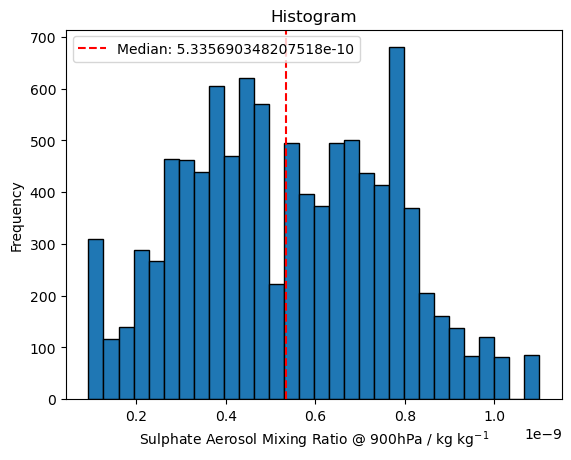

In [29]:
plt.hist(so2_data_colocated.flatten(), bins=30, edgecolor='black')

# Calculate the median value
median_value = np.median(so2_data_colocated)

# Add a vertical line for the median value
plt.axvline(x=median_value, color='red', linestyle='--', label=f'Median: {median_value:}')

# Add labels and title
plt.xlabel('Sulphate Aerosol Mixing Ratio @ 900hPa / kg kg$^{-1}$')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.legend()

# Show the plot
plt.show()

In [30]:
sulphate_critical = np.median(so2_data_colocated.flatten())

print(sulphate_critical)#


clean = so2_data_colocated < np.median(so2_data_colocated.flatten())  # define the condition for clean initial atmospheric condition, so2 concentrations less than 1e-15 kg/kg are True


GOES_LWP_transposed = np.transpose(GOES_LWP_reshaped, (1,0,2,3)) ## transpose the CF data so that the time is the first axis, this is so we can use the np.where function to find the indices of the clean and polluted conditions
LWP_corrected_transposed = np.transpose(LWP_corrected,(1,0,2,3))
GOES_cloud_mask = np.transpose(GOES_cloud_mask,(1,0,2,3)) ## transpose cloud mask so everything has same shape
AMSR_mask = np.transpose(AMSR_mask,(1,0,2,3))
zenith_mask_transposed = np.transpose(zenith_mask,(1,0,2,3))

AMSR_LWP_transposed = np.transpose(AMSR_LWP_reshaped, (1,0,2,3))
positions_transposed = np.transpose(positions_reshaped, (1,2,0,3,4)) ## transpose the positions data so that the time is the first axis, this is so we can use the np.where function to find the indices of the clean and polluted conditions

lon_time = positions_transposed[:,0,:,:,:] ## extract the lon and lat data from the positions data
lat_time = positions_transposed[:,1,:,:,:]


clean_expanded = np.expand_dims(clean, axis=0)  # Shape: (1, 10, 100, 100)

# Repeat clean along the first axis to match the number of timesteps in CF_transposed
clean_repeated = np.repeat(clean_expanded, len(GOES_LWP_transposed), axis=0) 

5.335690348207518e-10


In [31]:
## sort GOES stuff out
GOES_LWP_clean = ma.masked_array(GOES_LWP_transposed, mask=(~clean_repeated | GOES_cloud_mask))/1000 ## divide by 1000 so the units are g/m^2
GOES_LWP_polluted = ma.masked_array(GOES_LWP_transposed, mask=(clean_repeated|GOES_cloud_mask) )/1000

LWP_corrected_clean = ma.masked_array(LWP_corrected_transposed, mask=(~clean_repeated | GOES_cloud_mask|zenith_mask_transposed))/1000
LWP_corrected_polluted = ma.masked_array(LWP_corrected_transposed, mask=(clean_repeated | GOES_cloud_mask|zenith_mask_transposed))/1000

mean_GOES_LWP_clean= np.mean(GOES_LWP_clean, axis=(1, 2, 3))
mean_GOES_LWP_polluted = np.mean(GOES_LWP_polluted, axis=(1, 2, 3))
mean_corrected_LWP_clean = np.mean(LWP_corrected_clean,axis=(1,2,3))
mean_corrected_LWP_polluted = np.mean(LWP_corrected_polluted,axis=(1,2,3))

## repeat for AMSR

AMSR_LWP_clean = ma.masked_array(AMSR_LWP_transposed, mask=(~clean_repeated|AMSR_mask))
AMSR_LWP_polluted = ma.masked_array(AMSR_LWP_transposed, mask=(clean_repeated|AMSR_mask))

mean_AMSR_LWP_clean= np.mean(AMSR_LWP_clean, axis=(1, 2, 3))
mean_AMSR_LWP_polluted = np.mean(AMSR_LWP_polluted, axis=(1, 2, 3))


lon_clean = ma.masked_array(lon_time, mask=(~clean_repeated|GOES_cloud_mask))
lon_polluted = ma.masked_array(lon_time, mask=(clean_repeated|GOES_cloud_mask))
lat_clean = ma.masked_array(lat_time, mask=(~clean_repeated|GOES_cloud_mask))
lat_polluted = ma.masked_array(lat_time, mask=(clean_repeated|GOES_cloud_mask))

In [32]:
lon_clean = ma.masked_array(lon_time, mask=(~clean_repeated))
lon_polluted = ma.masked_array(lon_time, mask=(clean_repeated))
lat_clean = ma.masked_array(lat_time, mask=(~clean_repeated))
lat_polluted = ma.masked_array(lat_time, mask=(clean_repeated))

In [33]:

LWP_corrected_clean = ma.masked_array(LWP_corrected_transposed, mask=(~clean_repeated | GOES_cloud_mask|zenith_mask_transposed))/1000
LWP_corrected_polluted = ma.masked_array(LWP_corrected_transposed, mask=(clean_repeated | GOES_cloud_mask|zenith_mask_transposed))/1000

In [34]:
print(np.sum(zenith_mask_transposed))
print(np.sum(~zenith_mask_transposed))

301901
188099


In [35]:
mean_AMSR_LWP_clean = np.ma.masked_equal(mean_AMSR_LWP_clean, 0)
mean_AMSR_LWP_polluted = np.ma.masked_equal(mean_AMSR_LWP_polluted, 0)

In [36]:
# what does this cell do?

lon_clean_reshaped = lon_clean.reshape((len(lon_clean),-1))
lat_clean_reshaped = lat_clean.reshape((len(lat_clean),-1))
lon_polluted_reshaped = lon_polluted.reshape((len(lon_polluted),-1))
lat_polluted_reshaped = lat_polluted.reshape((len(lat_polluted),-1))

In [37]:
print(np.sum(lon_clean_reshaped.mask))
print(np.sum(lat_clean_reshaped.mask))
print(np.sum(lon_polluted_reshaped.mask))
print(np.sum(lat_polluted_reshaped.mask))

246470
246470
243530
243530


In [38]:
print(lon_clean_reshaped.shape)
print(lat_clean_reshaped.shape)

(49, 10000)
(49, 10000)


In [39]:
print(np.min(lon_clean_reshaped),np.max(lon_clean_reshaped))
print(np.min(lat_clean_reshaped),np.max(lat_clean_reshaped))

-148.0478869003626 -131.40866811332654
24.677785103692738 41.28405946527902


In [40]:
print(mean_corrected_LWP_clean)

[-- -- -- 170.55697434373587 139.0747027090446 124.89751283551965
 115.70646377464713 109.7976779291171 74.07501325095606 89.96972940074316
 -0.10965602307851138 81.36713681055048 79.68330564869281
 79.48491838583969 84.57092223593308 81.91639316306215 87.82725055926316
 80.15098666327698 94.87407790455909 129.66532904668335 120.63579305982209
 150.46083770672146 141.7547349316126 -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- --]


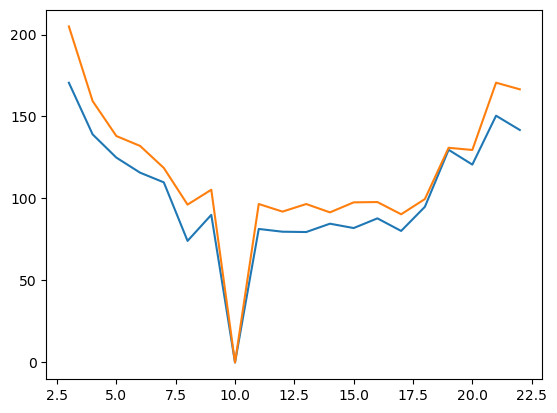

In [41]:
plt.plot(mean_corrected_LWP_clean)
plt.plot(mean_corrected_LWP_polluted)
plt.show()

In [42]:
### remove zeros, somthing to do this numpy mean returning zeros for masked elements

clean_corr_mask = mean_corrected_LWP_clean.mask
polluted_corr_mask = mean_corrected_LWP_polluted.mask

clean_zero_mask = mean_corrected_LWP_clean == 0
polluted_zero_mask = mean_corrected_LWP_polluted == 0

mean_corrected_LWP_clean.mask = clean_zero_mask | clean_corr_mask
mean_corrected_LWP_polluted.mask = polluted_zero_mask | polluted_corr_mask

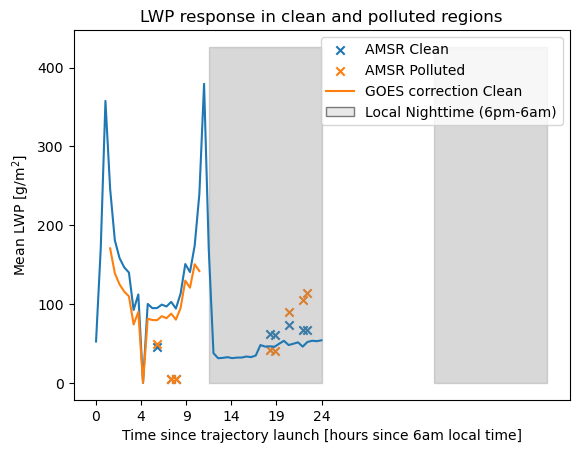

<Figure size 640x480 with 0 Axes>

In [43]:
fig, ax = plt.subplots()

# Plot mean cloud fraction for clean and polluted regions
ax.set_title('LWP response in clean and polluted regions')
clean_line, = ax.plot(mean_GOES_LWP_clean, label='GOES Clean')
#polluted_line, = ax.plot(mean_GOES_LWP_polluted, label='GOES Polluted')

clean_corrected, = ax.plot(mean_corrected_LWP_clean, label='GOES correction Clean')
#polluted_corrected, = ax.plot(mean_corrected_LWP_polluted, label='GOES correction Polluted')

AMSR_clean_line = ax.scatter(np.arange(len(mean_AMSR_LWP_clean)),mean_AMSR_LWP_clean, label='AMSR Clean',marker='x')
AMSR_polluted_line = ax.scatter(np.arange(len(mean_AMSR_LWP_polluted)),mean_AMSR_LWP_polluted, label='AMSR Polluted',marker='x')

#ax.set_ylabel('Mean cloud fraction')
ax.set_ylabel('Mean LWP [g/m$^2$]')
ax.set_xlabel('Time since trajectory launch [hours since 6am local time]')

# Set maximum time (in hours)
max_time = time_advected

# Calculate tick positions and labels
tick_positions = np.linspace(0, max_time*2, int(time_advected/4))
tick_labels = np.linspace(0, max_time, int(time_advected/4), dtype=int)

# Shade the regions between 0 and 9, and 21 and 24 hours
ax.fill_between([24,48], np.min([np.min(mean_GOES_LWP_clean),np.min(mean_GOES_LWP_polluted)]),np.max([np.max(mean_GOES_LWP_clean),np.max(mean_GOES_LWP_polluted)]), color='gray', alpha=0.3)
ax.fill_between([72,96], np.min([np.min(mean_GOES_LWP_clean),np.min(mean_GOES_LWP_polluted)]),np.max([np.max(mean_GOES_LWP_clean),np.max(mean_GOES_LWP_polluted)]), color='gray', alpha=0.3)
#ax.fill_between([120,144], np.min([np.min(mean_GOES_LWP_clean),np.min(mean_GOES_LWP_polluted)]),np.max([np.max(mean_GOES_LWP_clean),np.max(mean_GOES_LWP_polluted)]), color='gray', alpha=0.3)
#ax.fill_between([168,192], np.min([np.min(mean_GOES_LWP_clean),np.min(mean_GOES_LWP_polluted)]),np.max([np.max(mean_GOES_LWP_clean),np.max(mean_GOES_LWP_polluted)]), color='gray', alpha=0.3)

#ax.fill_between([120,144], np.min([np.min(mean_CF_clean),np.min(mean_CF_polluted)]),np.max([np.max(mean_CF_clean),np.max(mean_CF_polluted)]), color='gray', alpha=0.3)
#ax.fill_between([168,192], np.min([np.min(mean_CF_clean),np.min(mean_CF_polluted)]),np.max([np.max(mean_CF_clean),np.max(mean_CF_polluted)]), color='gray', alpha=0.3)
legend_elements = [mpatches.Patch(facecolor='lightgrey', edgecolor='black', alpha=0.5, label='Local Nighttime (6pm-6am)')]

handles = [AMSR_clean_line,AMSR_polluted_line,clean_corrected] + legend_elements #,clean_corrected,polluted_corrected ##clean_line, polluted_line, ,polluted_corrected

ax.legend(handles=handles)

# Set ticks and tick labels on the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

# Add legend to the plot
#ax.legend()

# Show the plot
plt.show()
plt.savefig('LWP_response_AMSR_validation_AMSR.png')

In [44]:
print(GOES_LWP_transposed.shape)
print(LWP_corrected_transposed.shape)

(49, 1, 100, 100)
(49, 1, 100, 100)


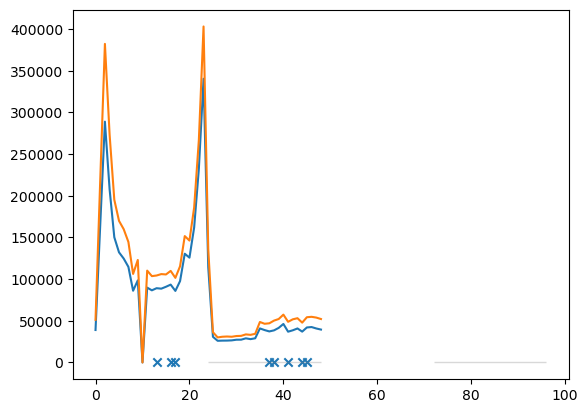

In [45]:
LWP_corrected_mean = np.mean(LWP_corrected_transposed,axis = (1,2,3))
GOES_LWP_mean = np.mean(GOES_LWP_transposed,axis = (1,2,3))

zero_mask = LWP_corrected_mean == 0
corr_mask = LWP_corrected_mean.mask

LWP_corrected_mean.mask = zero_mask |corr_mask



plt.plot(LWP_corrected_mean)
plt.plot(GOES_LWP_mean)
plt.scatter(np.arange(len(mean_AMSR_LWP_clean)),mean_AMSR_LWP_clean, label='AMSR Clean',marker='x')
plt.fill_between([24,48], np.min([np.min(mean_GOES_LWP_clean),np.min(mean_GOES_LWP_polluted)]),np.max([np.max(mean_GOES_LWP_clean),np.max(mean_GOES_LWP_polluted)]), color='gray', alpha=0.3)
plt.fill_between([72,96], np.min([np.min(mean_GOES_LWP_clean),np.min(mean_GOES_LWP_polluted)]),np.max([np.max(mean_GOES_LWP_clean),np.max(mean_GOES_LWP_polluted)]), color='gray', alpha=0.3)
plt.show()

In [46]:
print(np.mean(mean_corrected_LWP_clean))
print(np.mean(mean_corrected_LWP_polluted))

101.8180052168351
115.69564507291


In [47]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

In [ ]:

# Create a plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
plt.scatter(lon_clean_reshaped[48], lat_clean_reshaped[48], marker='o', color='red', transform=ccrs.PlateCarree())

# Add gridlines and coastlines
ax.gridlines(draw_labels=True)
ax.coastlines()

# Set plot title
plt.title('Latitude-Longitude Plot')

# Show the plot
plt.show()

In [ ]:
print(lon_clean_reshaped)
print(lon_polluted_reshaped)

lon_clean_filled = np.ma.filled(lon_clean_reshaped, fill_value=np.nan)
lat_clean_filled = np.ma.filled(lat_clean_reshaped, fill_value=np.nan)
lon_polluted_filled = np.ma.filled(lon_polluted_reshaped, fill_value=np.nan)
lat_polluted_filled = np.ma.filled(lat_polluted_reshaped, fill_value=np.nan)

print(lon_clean_filled)
print(lon_polluted_filled)



In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot clean data
heatmap_clean = axes[0].hexbin(lon_clean_filled[48], lat_clean_filled[48], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
axes[0].set_title('Clean Data')
axes[0].gridlines(draw_labels=True)
axes[0].coastlines()

# Add colorbar to the first subplot
cbar_clean = plt.colorbar(heatmap_clean, ax=axes[0], label='Density')

# Plot polluted data
heatmap_polluted = axes[1].hexbin(lon_polluted_filled[48], lat_polluted_filled[48], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
axes[1].set_title('Polluted Data')
axes[1].gridlines(draw_labels=True)
axes[1].coastlines()

# Add colorbar to the second subplot
cbar_polluted = plt.colorbar(heatmap_polluted, ax=axes[1], label='Density')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
print(positions_reshaped.shape)

lon_min = positions_reshaped[:,:,0,:,:].min()
lon_max = positions_reshaped[:,:,0,:,:].max()
lat_min = positions_reshaped[:,:,1,:,:].min()
lat_max = positions_reshaped[:,:,1,:,:].max()

print(lon_min,lon_max,lat_min,lat_max)

In [ ]:
import matplotlib.animation as animation

def update_plot(i):
    # Clear the previous colorbars
    if hasattr(update_plot, "cbar_clean"):
        update_plot.cbar_clean.remove()
    if hasattr(update_plot, "cbar_polluted"):
        update_plot.cbar_polluted.remove()

    # Clear the current clean data plot
    axes[0].clear()
    heatmap_clean = axes[0].hexbin(lon_clean_filled[i], lat_clean_filled[i], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
    axes[0].set_title(f'Clean Data - Time Step {int(i/2)}')
    axes[0].gridlines(draw_labels=True)
    axes[0].coastlines()
    axes[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set extent

    # Clear the current polluted data plot
    axes[1].clear()
    heatmap_polluted = axes[1].hexbin(lon_polluted_filled[i], lat_polluted_filled[i], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
    axes[1].set_title(f'Polluted Data - Time Step {int(i/2)}')
    axes[1].gridlines(draw_labels=True)
    axes[1].coastlines()
    axes[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set extent

# Compute the global minimum and maximum values for clean and polluted data
vmin_clean = np.min(heatmap_clean.get_array())
vmax_clean = np.max(heatmap_clean.get_array())
vmin_polluted = np.min(heatmap_polluted.get_array())
vmax_polluted = np.max(heatmap_polluted.get_array())

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust layout to prevent overlap
plt.tight_layout()

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(lon_clean_reshaped), interval=200)

# Create colorbars with the global minimum and maximum values
cbar_clean = plt.colorbar(heatmap_clean, ax=axes[0], label='Density', extend='max', extendfrac=0.05, orientation='vertical')
cbar_clean.set_ticks(np.linspace(vmin_clean, vmax_clean, num=5))  # Adjust number of ticks as needed
cbar_polluted = plt.colorbar(heatmap_polluted, ax=axes[1], label='Density', extend='max', extendfrac=0.05, orientation='vertical')
cbar_polluted.set_ticks(np.linspace(vmin_polluted, vmax_polluted, num=5))  # Adjust number of ticks as needed

# Save the animation as a GIF
#ani.save(f'clean_polluted_data_animation_single day_{time_advected}.gif', writer='imagemagick')

In [ ]:
import matplotlib.animation as animation

def update_plot(i):
    # Clear the previous colorbars
    if hasattr(update_plot, "cbar_clean"):
        update_plot.cbar_clean.remove()
    if hasattr(update_plot, "cbar_polluted"):
        update_plot.cbar_polluted.remove()

    # Clear the current clean data plot
    axes[0].clear()
    heatmap_clean = axes[0].hexbin(lon_clean_filled[i], lat_clean_filled[i], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
    axes[0].set_title(f'Clean Data - Time Step {int(i/2)}')
    axes[0].gridlines(draw_labels=True)
    axes[0].coastlines()
    axes[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set extent

    # Clear the current polluted data plot
    axes[1].clear()
    heatmap_polluted = axes[1].hexbin(lon_polluted_filled[i], lat_polluted_filled[i], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
    axes[1].set_title(f'Polluted Data - Time Step {int(i/2)}')
    axes[1].gridlines(draw_labels=True)
    axes[1].coastlines()
    axes[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set extent

# Compute the global minimum and maximum values for clean and polluted data
vmin_clean = np.min(heatmap_clean.get_array())
vmax_clean = np.max(heatmap_clean.get_array())
vmin_polluted = np.min(heatmap_polluted.get_array())
vmax_polluted = np.max(heatmap_polluted.get_array())

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust layout to prevent overlap
plt.tight_layout()

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(lon_clean_reshaped), interval=200)

cmap_white_to_max = plt.cm.get_cmap('Blues')  # You can choose any colormap you like
cmap_white_to_max.set_under(color='white')  # Set the color for values below vmin

cbar_clean = plt.colorbar(heatmap_clean, ax=axes[0], label='Density', extend='max', extendfrac=0.05, orientation='vertical', cmap=cmap_white_to_max)
cbar_clean.set_ticks(np.linspace(vmin_clean, vmax_clean, num=5))  # Adjust number of ticks as needed

cbar_polluted = plt.colorbar(heatmap_polluted, ax=axes[1], label='Density', extend='max', extendfrac=0.05, orientation='vertical', cmap=cmap_white_to_max)
cbar_polluted.set_ticks(np.linspace(vmin_polluted, vmax_polluted, num=5))  # Adjust number of ticks as needed



# Save the animation as a GIF
ani.save(f'clean_polluted_data_animation_single day_{time_advected}.gif', writer='imagemagick')

In [ ]:
print(stop_here)

In [ ]:
# Create a function to update the plots for each timestep
import matplotlib.animation as animation

def update_plot(i):
    # Clear the previous colorbars
    if hasattr(update_plot, "cbar_clean"):
        update_plot.cbar_clean.remove()
    if hasattr(update_plot, "cbar_polluted"):
        update_plot.cbar_polluted.remove()

    # Clear the current clean data plot
    axes[0].clear()
    heatmap_clean = axes[0].hexbin(lon_clean_filled[i], lat_clean_filled[i], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
    axes[0].set_title(f'Clean Data - Time Step {int(i/2)}')
    axes[0].gridlines(draw_labels=True)
    axes[0].coastlines()
    axes[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set extent

    update_plot.cbar_clean = plt.colorbar(heatmap_clean, ax=axes[0], label='Density')

    # Clear the current polluted data plot
    axes[1].clear()
    heatmap_polluted = axes[1].hexbin(lon_polluted_filled[i], lat_polluted_filled[i], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
    axes[1].set_title(f'Polluted Data - Time Step {int(i/2)}')
    axes[1].gridlines(draw_labels=True)
    axes[1].coastlines()
    axes[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set extent

    update_plot.cbar_polluted = plt.colorbar(heatmap_polluted, ax=axes[1], label='Density')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust layout to prevent overlap
plt.tight_layout()

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(lon_clean_reshaped), interval=200)

# Save the animation as a GIF
ani.save('clean_polluted_data_animation_48.gif', writer='imagemagick')

In [ ]:
print(np.sum(lon_clean_reshaped.mask))
print(np.sum(lat_clean_reshaped.mask))
print(np.sum(lon_polluted_reshaped.mask))
print(np.sum(lat_polluted_reshaped.mask))

In [ ]:
def update_plot(i):
    # Clear the previous colorbars
    if hasattr(update_plot, "cbar_clean"):
        update_plot.cbar_clean.remove()
    if hasattr(update_plot, "cbar_polluted"):
        update_plot.cbar_polluted.remove()

    # Clear the current clean data plot
    axes[0].clear()
    heatmap_clean = axes[0].hexbin(lon_clean_filled[i], lat_clean_filled[i], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
    axes[0].set_title(f'Clean Data - Time Step {int(i/2)}')
    axes[0].gridlines(draw_labels=True)
    axes[0].coastlines()
    axes[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set extent

    # Manually specify colorbar limits based on data range
    vmin_clean = 0  # Minimum value for color scale
    vmax_clean = np.max(heatmap_clean.get_array())  # Maximum value for color scale

    update_plot.cbar_clean = plt.colorbar(heatmap_clean, ax=axes[0], label='Density', extend='max', extendfrac=0.05, orientation='horizontal')
    update_plot.cbar_clean.set_ticks(np.linspace(vmin_clean, vmax_clean, num=5))  # Adjust number of ticks as needed

    # Clear the current polluted data plot
    axes[1].clear()
    heatmap_polluted = axes[1].hexbin(lon_polluted_filled[i], lat_polluted_filled[i], gridsize=30, cmap='Blues', transform=ccrs.PlateCarree())
    axes[1].set_title(f'Polluted Data - Time Step {int(i/2)}')
    axes[1].gridlines(draw_labels=True)
    axes[1].coastlines()
    axes[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set extent

    # Manually specify colorbar limits based on data range
    vmin_polluted = 0  # Minimum value for color scale
    vmax_polluted = np.max(heatmap_polluted.get_array())  # Maximum value for color scale

    update_plot.cbar_polluted = plt.colorbar(heatmap_polluted, ax=axes[1], label='Density', extend='max', extendfrac=0.05, orientation='horizontal')
    update_plot.cbar_polluted.set_ticks(np.linspace(vmin_polluted, vmax_polluted, num=5))  # Adjust number of ticks as needed

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust layout to prevent overlap
plt.tight_layout()

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(lon_clean_reshaped), interval=200)

# Save the animation as a GIF
ani.save('clean_polluted_data_animation_48.gif', writer='imagemagick')


In [ ]:
# initialize CF_test array, this will store the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched

CF_test = np.zeros((n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched
positions_time = np.zeros((n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,2,int(region_size/resample_size),int(region_size/resample_size)))

#LWP_reshaped = np.zeros((n_trajectories,int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,int(region_size/resample_size),int(region_size/resample_size))) ## stores the CF values, reshapes CF so that all the rows correspond to the same time since the trjactory was launched

for i in range(n_trajectories):
    CF_test[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:] = CF[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:]
    #LWP_reshaped[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:] = LWP[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:]
    positions_time[i,0:int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds())+1,:,:,:] = positions_all[i,i*int(time_between_trajectroies/time_step):i*int(time_between_trajectroies/time_step)+int(datetime.timedelta(hours=time_advected).total_seconds() / time_step.total_seconds()) +1,:,:,:]

# mask out NaN values

CF_test = np.ma.masked_invalid(CF_test)
positions_time = np.ma.masked_invalid(positions_time)

## ignore repeated indices for obvious reasons!

index_to_skip = np.unique(index_to_skip)

print(index_to_skip)

#LWP_reshaped = np.ma.masked_invalid(LWP_reshaped)

In [ ]:
print(positions_all.shape)
print(CF_test.shape)
print(positions_time.shape)

#positions

In [ ]:
# Path to the NetCDF file
file_path = f'/disk1/Data/CAMS/aerosol_levels/{year}/04/{year}-04-01-{year}-04-30.nc'

# Open the NetCDF file
nc_file = Dataset(file_path)

so2_data = nc_file.variables['aermr11'][:]

time_data = nc_file.variables['time'][:]

level_data = nc_file.variables['level'][:]

lon = nc_file.variables['longitude'][:]

lat = nc_file.variables['latitude'][:]

print(nc_file.variables.keys())

In [ ]:
## sort out times, hours since 1900 blah blah blah

time_mask = time_data.mask

timedelta_array = np.array([timedelta(hours=int(h)) for h in time_data.data])

reference_date = datetime.datetime(1900, 1, 1, 0, 0, 0)

CAMS_times = reference_date + timedelta_array ## note times are UTC

In [ ]:
### Generalize all of so2 stuff e.g. so I dont need to hand change it, as this si how mistakes are made!!!!!

## FOR INSRTANCE THE INDEX SLICING AND THE LEVELS

slice = int(time_advected/3)

In [ ]:
CAMS_times_sliced1 = CAMS_times[5:]  # remove first five timesteps so we start at 15:00 UTC this is a bit hacky and could be generalized

CAMS_times_sliced = CAMS_times_sliced1[::slice]  ## select every 8th time step, so each time step is 24 hours apart, 16 here corresponds to 48 hours

In [ ]:
so2_data_sliced1 = so2_data[5:,:,:,:] # remove first five timesteps so we start at 15:00 UTC

so2_data_sliced = so2_data_sliced1[::slice,8,:,:] ## 8th pressure level corresponds to 900hPa so that the array has the form (day,lat,lon)

so2_data_sliced = so2_data_sliced[:n_trajectories,:,:] ## slice the data so it has the same number of trajectories as the GOES data

In [ ]:
so2_data_colocated = [] # initialize list to store colocated SO2 data

## this loop is to fund the initial SO2 conecentration at the initial position of the parcel

for i in range(n_trajectories): # 
    init_position = init_position_all[i]
    init_lon = init_position[0]
    init_lat = init_position[1]
    so2_data_loop = so2_data_sliced[i,:,:]
    
    lat_diff = np.abs(init_lat[:, :, np.newaxis] -lat) 

    lat_indices = np.argmin(lat_diff, axis=-1)

    lon_diff = np.abs(init_lon[:, :, np.newaxis] - lon)
    lon_indices = np.argmin(lon_diff, axis=-1)

    so2_data = so2_data_sliced[i,:,:] ## format (lat,lon)

    so2_data_colocated.append(so2_data[lat_indices,lon_indices])

so2_data_colocated = np.array(so2_data_colocated)


In [ ]:
plt.hist(so2_data_colocated.flatten(), bins=30, edgecolor='black')

# Calculate the median value
median_value = np.median(so2_data_colocated)

# Add a vertical line for the median value
plt.axvline(x=median_value, color='red', linestyle='--', label=f'Median: {median_value:}')

# Add labels and title
plt.xlabel('Sulphate Aerosol Mixing Ratio @ 900hPa / kg kg$^{-1}$')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.legend()

# Show the plot
plt.show()

In [ ]:
sulphate_critical = np.median(so2_data_colocated.flatten())

print(sulphate_critical)#


clean = so2_data_colocated < np.median(so2_data_colocated.flatten())  # define the condition for clean initial atmospheric condition, so2 concentrations less than 1e-15 kg/kg are True


CF_transposed = np.transpose(CF_test, (1,0,2,3)) ## transpose the CF data so that the time is the first axis, this is so we can use the np.where function to find the indices of the clean and polluted conditions



clean_expanded = np.expand_dims(clean, axis=0)  # Shape: (1, 10, 100, 100)

# Repeat clean along the first axis to match the number of timesteps in CF_transposed
clean_repeated = np.repeat(clean_expanded, len(CF_transposed), axis=0) 

In [ ]:
print(positions_time.shape)


In [ ]:
### sort out positions

positions_transposed = np.transpose(positions_time, (1,2,0,3,4)) ## transpose the positions data so that the time is the first axis, this is so we can use the np.where function to find the indices of the clean and polluted conditions

lon_time = positions_transposed[:,0,:,:,:] ## extract the lon and lat data from the positions data
lat_time = positions_transposed[:,1,:,:,:]

In [ ]:
CF_clean = ma.masked_array(CF_transposed, mask=~clean_repeated)
CF_polluted = ma.masked_array(CF_transposed, mask=clean_repeated)
lon_clean = ma.masked_array(lon_time, mask=~clean_repeated)
lon_polluted = ma.masked_array(lon_time, mask=clean_repeated)
lat_clean = ma.masked_array(lat_time, mask=~clean_repeated)
lat_polluted = ma.masked_array(lat_time, mask=clean_repeated)


mean_CF_clean= np.mean(CF_clean, axis=(1, 2, 3))
mean_CF_polluted = np.mean(CF_polluted, axis=(1, 2, 3))

In [ ]:
mean_CF_polluted = mean_CF_polluted/1000 ## sort units out
mean_CF_clean = mean_CF_clean/1000

In [ ]:
lon_clean_reshaped = lon_clean.reshape((len(lon_clean),-1))
lat_clean_reshaped = lat_clean.reshape((len(lat_clean),-1))
lon_polluted_reshaped = lon_polluted.reshape((len(lon_polluted),-1))
lat_polluted_reshaped = lat_polluted.reshape((len(lat_polluted),-1))

In [ ]:
lon_array = lon_clean_reshaped
lat_array = lat_clean_reshaped

lon_grid, lat_grid = np.meshgrid(np.arange(lon_array.shape[1]), np.arange(lon_array.shape[0]))

# Plot the latitude and longitude on a grid
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
lon_scatter = ax.scatter(lon_grid, lat_grid, c=lon_array, cmap='viridis', s=2, transform=ccrs.PlateCarree(), label='Longitude')
lat_scatter = ax.scatter(lon_grid, lat_grid, c=lat_array, cmap='viridis', s=2, transform=ccrs.PlateCarree(), label='Latitude')

# Create a dummy scatter plot for colorbar
dummy = ax.scatter([], [], c=[], cmap='viridis')
plt.colorbar(dummy, label='Value')

plt.title('Latitude and Longitude on Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots()

# Plot mean cloud fraction for clean and polluted regions
ax.set_title('LWP response in clean and polluted regions')
clean_line, = ax.plot(mean_CF_clean, label='Clean')
polluted_line, = ax.plot(mean_CF_polluted, label='Polluted')
#ax.set_ylabel('Mean cloud fraction')
ax.set_ylabel('Mean LWP [g/m$^2$]')
ax.set_xlabel('Time since trajectory launch [hours since 6am local time]')

# Set maximum time (in hours)
max_time = time_advected

# Calculate tick positions and labels
tick_positions = np.linspace(0, max_time*2, int(time_advected/4))
tick_labels = np.linspace(0, max_time, int(time_advected/4), dtype=int)

# Shade the regions between 0 and 9, and 21 and 24 hours
ax.fill_between([24,48], np.min([np.min(mean_CF_clean),np.min(mean_CF_polluted)]),np.max([np.max(mean_CF_clean),np.max(mean_CF_polluted)]), color='gray', alpha=0.3)
#ax.fill_between([72,96], np.min([np.min(mean_CF_clean),np.min(mean_CF_polluted)]),np.max([np.max(mean_CF_clean),np.max(mean_CF_polluted)]), color='gray', alpha=0.3)
#ax.fill_between([120,144], np.min([np.min(mean_CF_clean),np.min(mean_CF_polluted)]),np.max([np.max(mean_CF_clean),np.max(mean_CF_polluted)]), color='gray', alpha=0.3)
#ax.fill_between([168,192], np.min([np.min(mean_CF_clean),np.min(mean_CF_polluted)]),np.max([np.max(mean_CF_clean),np.max(mean_CF_polluted)]), color='gray', alpha=0.3)
legend_elements = [mpatches.Patch(facecolor='lightgrey', edgecolor='black', alpha=0.5, label='Local Nighttime (6pm-6am)')]

handles = [clean_line, polluted_line] + legend_elements

ax.legend(handles=handles)

# Set ticks and tick labels on the x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

# Add legend to the plot
#ax.legend()

# Show the plot
plt.show()